## INFO

This is a notebook to highlight the Tweedie Compound Poisson Gamma (TCPG) ealstic net that was developed byt he Data Science team based on the following:

- https://cran.r-project.org/web/packages/HDtweedie/HDtweedie.pdf
- https://www.math.mcgill.ca/yyang/resources/papers/JCGS_HDtweedie.pdf

The elastic net code should be provided as well and it uses a "Fish" data set that is considered a useful test set. 

Please note that TCPG is only valid for solutions of powers between 1.0 and 2.0.

<font color=red size=4>**This version is straight  forward and only compares results.**</font>


<font color=blue size=4>**Links for comparison to SAS:**</font>

- https://stats.stackexchange.com/questions/400663/sas-and-r-gives-different-standard-error-when-fitting-tweedie-model

- *GEE Models not available for Tweedie Distribution*


<font color=green size=4>**This version is for comparing profile generators for optimal tweedie power. 2022-03-04**</font>

In [1]:
## SOME EXTENSIONS MIGHT NOT LOAD 
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sidetable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sma
import scipy as sp

from sklearn.metrics import mean_tweedie_deviance, mean_absolute_error

import os
import gc

import shap
import eli5

pd.set_option('max_columns', 150)
pd.set_option('max_rows', 100)

In [3]:
import os
##  you must then set your R HOME before importing the module - it should be in a similar location as below

os.environ['R_HOME'] = 'C:/Users/schillw/Anaconda3/envs/fnb/Lib/R'


**As long as the environment part of the path above - the "fnb" matches your environment that you are working in.**

In [4]:
from rpy2.robjects import r
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2 import robjects
import rpy2
pandas2ri.activate()

import sys
print("Python version should be 3.7.9.")
print("Current Python Version: {}".format(sys.version))
print("rpy2 Version = ", rpy2.__version__)

print("\nR VERSION = ", r.version)

Python version should be 3.7.9.
Current Python Version: 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
rpy2 Version =  3.4.5

R VERSION =                 _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          3                           
minor          6.3                         
year           2020                        
month          02                          
day            29                          
svn rev        77875                       
language       R                           
version.string R version 3.6.3 (2020-02-29)
nickname       Holding the Windsock        



In [5]:
from fnbbase.models import TweedieElasticNet

## Fish Data

I cant find the link but there are 5 variables where FISH_COUNT is our dependent variable based on how many were caught.

In [6]:
fish_data = pd.read_csv('data/fish.csv')
fish_data.head()

LIVE_BAIT  CAMPER  PERSONS  CHILDREN  FISH_COUNT
0          0       0        1         0           0
1          1       1        1         0           0
2          1       0        1         0           0
3          1       1        2         1           0
4          1       0        1         0           1

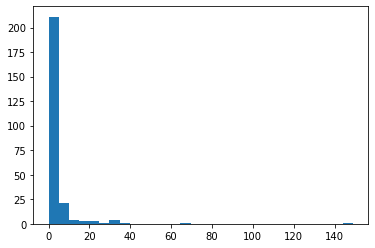

In [7]:
xf = fish_data.drop('FISH_COUNT',axis=1)
yf = fish_data['FISH_COUNT']

plt.hist(yf, bins=30);

**Here we see the distribution of the fishing data highlighting that it has a mass at zero and is discrete.**

In [8]:
(yf == 0).sum() / len(yf)

0.568

The data is about 56.8% 0.

**We must scale the exogenous variables (all others but y) to get an accurate assessment.**

In [9]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

X = xf.copy() #ss.fit_transform(xf) #x.values
y = yf.values.reshape(-1,1)

xfs = pd.DataFrame(X, columns=xf.columns, index=xf.index)

xf.describe()

LIVE_BAIT      CAMPER    PERSONS    CHILDREN
count  250.000000  250.000000  250.00000  250.000000
mean     0.864000    0.588000    2.52800    0.684000
std      0.343476    0.493182    1.11273    0.850315
min      0.000000    0.000000    1.00000    0.000000
25%      1.000000    0.000000    2.00000    0.000000
50%      1.000000    1.000000    2.00000    0.000000
75%      1.000000    1.000000    4.00000    1.000000
max      1.000000    1.000000    4.00000    3.000000

### STATSMODELS - PYTHON

In [10]:
## intial estimation, HC3 error

p0 = 1.5

twd = sma.GLM(endog=y, exog=sma.add_constant(xfs), family=sma.families.Tweedie(var_power=p0, eql=True))
res = twd.fit(cov_type='HC3', maxiter=1000, tol=1e-12)
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  250
Model:                            GLM   Df Residuals:                      245
Model Family:                 Tweedie   Df Model:                            4
Link Function:                    log   Scale:                          7.4412
Method:                          IRLS   Log-Likelihood:                -553.55
Date:                Tue, 29 Mar 2022   Deviance:                       859.06
Time:                        09:04:23   Pearson chi2:                 1.82e+03
No. Iterations:                    21                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0817      0.452     -6.824      0.0

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


**ReEstimate Tweedie Power**

In [11]:
print("Estimated Tweedie Power using R Method Built into TweedieElasticNet")
etp = TweedieElasticNet.r_tweedie_power_est(yf, sma.add_constant(xfs), figsize=None)
print(etp[0])

Estimated Tweedie Power using R Method Built into TweedieElasticNet


R object inheriting from "POSIXct" but without attribute "tzone".


1.1 1.15 1.2 1.25 1.3 1.35 1.4 1.45 1.5 1.55 1.6 1.65 1.7 1.75 1.8 1.85 1.9 
.................Done.
1.4102040816326533


In [12]:
twd.estimate_tweedie_power(res.mu)

1.630742735857726

116.74432130849385


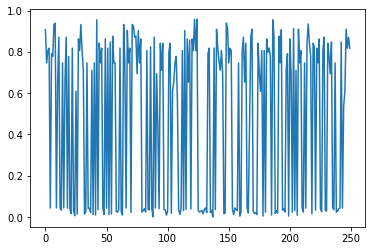

In [13]:
import tweedie_dist
import scipy as sp
twdgen = tweedie_dist.tweedie_gen()

## pdf according to quackdaddy
# density = twdgen._pdf(yf, p0, res.mu, res.scale)
density = tweedie_dist.tweedie(mu=res.mu, p=p0, phi=res.scale).pdf(yf)
print(density.sum())
plt.plot(density);

In [14]:
def estimate_x2_scale(y, mu, p, weights):
    resid = np.power(y - mu, 2) * weights
    df_resid = len(y)
    return np.sum(resid / np.power(mu, p)) / df_resid

def dispersion(y, yhat):
    '''sas genmod dispersion'''
    resid = y - yhat
    dof = len(y)
    disp = 1/(resid - dof - 1) * np.sum(resid**2)
    return disp

## x2 scale and dispersion above are NOT the same but potentially should be?


def loglike_p(p, res):
    return -tweedie_dist.tweedie(mu=res.mu, p=p, phi=res.scale).logpdf(res._endog).sum()

def optm(p, res):
    opt = sp.optimize.minimize_scalar(loglike_p, tol=1e-12, 
                                      bounds=(1.05, 1.95), args=(res), method='bounded')
    return opt

print(optm(p0, res))

     fun: 442.7833632815515
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 1.5403113885983206


Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.


- https://github.com/thequackdaddy/statsmodels/blob/estimate_tweedie/statsmodels/genmod/generalized_linear_model.py

**In Dunn Smyth paper:**
- phi = dispersion
- mu = mean of distribution

- for series expansion:
    - alpha = shape parameter
    - gamma = scale parameter

In [15]:
mu = res.mu
p = 1.5
phi = estimate_x2_scale(res.model.endog, mu, 1.5, res.model.iweights)
# print(phi, dispersion(res.model.endog, mu).sum())
# phi = dispersion(res.model.endog, mu)

dens = tweedie_dist.tweedie(mu=mu, p=1.5, phi=phi).pdf(res.model.endog)

In [16]:
def lam_alp_gam(mu, p, phi):
    l = mu**(2-p)/(phi*(2-p))
    a = (2-p)/(1-p)
    g = phi*(p-1)*mu**(p-1)
    return l, a, g

lam, alp, gam = lam_alp_gam(mu, p, phi)

In [17]:
lam, alp, gam

(array([0.09963754, 0.2986539 , 0.21992499, 0.20516207, 0.21992499,
        0.23904659, 0.25624776, 0.07129535, 0.06385197, 0.2986539 ,
        0.434627  , 0.1409373 , 0.28663962, 0.63268542, 0.2986539 ,
        0.2986539 , 0.434627  , 0.1409373 , 0.20516207, 0.25624776,
        0.434627  , 1.45726337, 0.20516207, 0.5065529 , 0.8591746 ,
        0.5065529 , 1.45726337, 0.15107878, 0.21992499, 0.07129535,
        0.21992499, 0.34797952, 1.45726337, 0.59021508, 0.2986539 ,
        0.16899723, 0.20516207, 0.59021508, 0.34797952, 0.59021508,
        0.2986539 , 1.45726337, 0.04701979, 0.6602166 , 0.17603092,
        0.2986539 , 0.20516207, 0.21992499, 0.20516207, 0.15107878,
        0.20516207, 0.20516207, 1.45726337, 0.16899723, 0.8591746 ,
        0.13530585, 0.2986539 , 0.2986539 , 0.59021508, 0.2986539 ,
        0.37301922, 0.20516207, 0.15107878, 1.45726337, 0.07129535,
        0.2986539 , 0.21992499, 0.10378446, 0.2986539 , 0.20516207,
        0.8591746 , 0.07129535, 0.07975122, 0.14

In [18]:
def optimize_twd_pwr_qd(y, mu, p, weights):
    ## from quack daddy :
    ## https://github.com/thequackdaddy/statsmodels/blob/estimate_tweedie/statsmodels/genmod/generalized_linear_model.py
    from scipy.optimize import brentq, minimize_scalar
    ## no change in minimize or various methods

    def psi_p(power, scale, y, mu):
        psi = ((y - mu) ** 2 / (scale * (mu ** power)) - 1)
        psi *= np.log(mu) * weights
        return psi.sum()

    def estimate_x2_scale(y, mu, p):
        resid = np.power(y - mu, 2) * weights
        df_resid = len(y)
        return np.sum(resid / np.power(mu, p)) / df_resid

    def difference(p):
        scale = estimate_x2_scale(y, mu, p)
        new_p = brentq(psi_p, -100, 100., args=(scale, y, mu)) ##brenth and ridder same as brentq
        return np.abs(new_p - p)

    power = minimize_scalar(difference, bounds=(1.05, 1.95), method='bounded', tol=1e-20)
    
    return power

In [19]:
optimize_twd_pwr_qd(res.model.endog, res.mu, 1.5, res.model.iweights)

     fun: 3.6698855065964153e-09
 message: 'Solution found.'
    nfev: 23
  status: 0
 success: True
       x: 1.6326041315726691

### Dunn & Smyth Paper

In [20]:
def j_max(y,p,phi):
    return y**(2-p)/(phi*(2-p))

jmax = j_max(res.model.endog, 1.5, phi)
print(jmax, '\n\n', np.argmin(jmax), np.argmax(jmax), )

[0.         0.         0.         0.         0.2742579  0.
 0.         0.         0.         0.2742579  0.         0.
 0.2742579  0.38785923 0.         0.2742579  0.         0.
 0.2742579  0.         0.2742579  0.6132593  0.         0.47502861
 1.50217236 0.         0.9888509  0.         0.         0.
 0.         0.         0.90961053 0.6132593  0.         0.2742579
 0.2742579  0.72561819 0.         1.02617908 0.         1.55143694
 0.         0.2742579  0.         0.         0.         0.2742579
 0.6132593  0.         0.2742579  0.         1.28638355 0.
 1.06219626 0.         0.         0.         0.6132593  0.54851579
 0.38785923 0.         0.38785923 1.55143694 0.         0.
 0.2742579  0.         0.         0.         0.72561819 0.
 0.         0.         0.         0.         0.         0.
 0.         0.38785923 0.47502861 0.2742579  0.6132593  0.
 0.38785923 0.2742579  0.         0.2742579  3.34774425 0.
 0.2742579  0.         0.         0.2742579  0.         0.
 0.         0.3878

In [21]:
def log_w_max(jmax, alp):
    lwm = jmax*(alp-1) - np.log(2*np.pi) - np.log(jmax) - 1/2*np.log(-alp)
    return lwm

lwjmax = log_w_max(jmax, alp)
print(lwjmax[:10])

[        inf         inf         inf         inf -1.09270646         inf
         inf         inf         inf -1.09270646]


divide by zero encountered in log


In [22]:
def logWj(y, p, phi, j, alp):
    from scipy.special import gammaln
    
    ztop = y**(-alp) * (p-1)**alp
    zbot = phi**(1-alp) * (2-p)
    z = ztop/zbot
    
    lwj = j*np.log(z) - gammaln(1+j) - gammaln(-alp*j)
    
    return lwj


log_w_j = logWj(res.model.endog, 1.5, phi, 88, alp)
print(log_w_j[:20])

[         -inf          -inf          -inf          -inf -841.53985533
          -inf          -inf          -inf          -inf -841.53985533
          -inf          -inf -841.53985533 -780.54290344          -inf
 -841.53985533          -inf          -inf -841.53985533          -inf]


divide by zero encountered in log


In [23]:
sum_lwj = 0
for i in range(1,88):
    sum_lwj = logWj(res.model.endog, 1.5, phi, i, alp)

print(sum_lwj[:20])

[         -inf          -inf          -inf          -inf -830.00923761
          -inf          -inf          -inf          -inf -830.00923761
          -inf          -inf -830.00923761 -769.7054329           -inf
 -830.00923761          -inf          -inf -830.00923761          -inf]


divide by zero encountered in log


In [24]:
np.exp(sum_lwj - lwjmax).sum()

6.753351906498439e-168

In [25]:
for pwr in np.arange(1.05,1.95,.05):
    
    mod = sma.GLM(endog=y, exog=sma.add_constant(xfs), family=sma.families.Tweedie(var_power=pwr, eql=True), offset=None)
    res = mod.fit(cov_type='HC3', maxiter=1000, tol=1e-12) 
    
    phi = estimate_x2_scale(res.model.endog, res.mu, pwr, res.model.iweights)
#     phi = dispersion(res.model.endog, res.mu)
    
    lam, alp, gam = lam_alp_gam(res.mu, pwr, phi)
    
    jm = j_max(res.model.endog, pwr, phi)
    
    lwjmax = log_w_max(jm, alp)
    
    print(pwr, np.ma.masked_invalid(lwjmax).sum())

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
divide by zero encountered in log


1.05 -1806.7623370841402
1.1 -959.4853253263788
1.1500000000000001 -670.7542677058339
1.2000000000000002 -523.9218532895
1.2500000000000002 -434.6523988688183
1.3000000000000003 -374.5486246343219
1.3500000000000003 -331.34776418858064
1.4000000000000004 -298.9016916203068
1.4500000000000004 -273.819553201334
1.5000000000000004 -254.12453843682331
1.5500000000000005 -238.65318003921345
1.6000000000000005 -226.77633893052808
1.6500000000000006 -218.28982445317473
1.7000000000000006 -213.43318878971084
1.7500000000000007 -213.07841412283432
1.8000000000000007 -219.29077609232382
1.8500000000000008 -237.03255784328456
1.9000000000000008 -280.7763657051517


### Smyth 1996

- https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.643.9431&rep=rep1&type=pdf

In [26]:
for pwr in np.arange(1.05,1.95,.05):
    pwr = np.round(pwr,2)
    
    mod = sma.GLM(endog=y, exog=sma.add_constant(xfs), family=sma.families.Tweedie(var_power=pwr, eql=True), offset=None)
    res = mod.fit(cov_type='HC3', maxiter=1000, tol=1e-12) 
    
    top = (y - res.mu)**2
    bot = res.mu**pwr
    
    print(pwr, np.sum(top/bot)/1e7)

1.05 2.4229369415092217
1.1 2.6383812383860694
1.15 2.8935446577460007
1.2 3.1987156170166116
1.25 3.5675634111693553
1.3 4.018515671595389
1.35 4.576820680385033
1.4 5.277700547039487
1.45 6.171286523802033
1.5 7.330548924412501
1.55 8.864420199783199
1.6 10.94025031028657
1.65 13.823727145984474
1.7 17.953045838136436
1.75 24.08400060034664
1.8 33.591722505756465
1.85 49.146352564778454
1.9 76.37114791670767


### many things point to optimizing the logliklihood estimate

- IRLS and NEWTON methods with lower tolerance and higher max iters both converged to 1.48 rather than 1.55 that the other is doing

In [27]:
data = []
for pwr in np.arange(1.05,1.95,.01):
    pwr = np.round(pwr,2)
    
    mod = sma.GLM(endog=y, exog=sma.add_constant(xfs), family=sma.families.Tweedie(var_power=pwr, eql=True), offset=None)
    res = mod.fit(cov_type='HC3', maxiter=10000, tol=1e-20, method='irls') 
    
    
    phi = estimate_x2_scale(res.model.endog, res.mu, pwr, res.model.iweights)
    
    lle = tweedie_dist.estimate_tweedie_loglike_series(res.model.endog, res.mu, 
                                                         phi*np.ones(len(res.model.endog)), 
                                                         pwr*np.ones(len(res.model.endog)))
#     llem = lle.mean()
    lles = lle.sum()
    data.append([pwr, lles, res.llf])

pd.DataFrame(data, columns=['pwr','llesum','llf'])

pwr       llesum         llf
0   1.05 -1564.604015 -583.357227
1   1.06 -1337.062125 -582.034870
2   1.07 -1175.903429 -580.742709
3   1.08 -1056.093520 -579.480579
4   1.09  -963.759399 -578.248326
5   1.10  -890.597308 -577.045800
6   1.11  -831.335304 -575.872861
7   1.12  -782.466578 -574.729380
8   1.13  -741.568504 -573.615236
9   1.14  -706.914187 -572.530320
10  1.15  -677.239787 -571.474534
11  1.16  -651.599338 -570.447793
12  1.17  -629.270949 -569.450024
13  1.18  -609.694344 -568.481168
14  1.19  -592.428185 -567.541181
15  1.20  -577.120215 -566.630034
16  1.21  -563.485962 -565.747716
17  1.22  -551.293259 -564.894230
18  1.23  -540.350815 -564.069601
19  1.24  -530.499653 -563.273872
20  1.25  -521.606601 -562.507104
21  1.26  -513.559304 -561.769384
22  1.27  -506.262335 -561.060818
23  1.28  -499.634153 -560.381540
24  1.29  -493.604694 -559.731706
25  1.30  -488.113439 -559.111501
26  1.31  -483.107869 -558.521139
27  1.32  -478.542209 -557.960863
28  1.33  -474.376397 -557.430950
29  1.34  -470.575252 -556.931710
30  1.35  -467.107767 -556.463492
31  1.36  -463.946540 -556.026680
32  1.37  -461.067286 -555.621704
33  1.38  -458.448434 -555.249035
34  1.39  -456.070784 -554.909193
35  1.40  -453.917219 -554.602749
36  1.41  -451.972458 -554.330329
37  1.42  -450.222847 -554.092615
38  1.43  -448.656177 -553.890356
39  1.44  -447.261536 -553.724366
40  1.45  -446.029168 -553.595534
41  1.46  -444.950367 -553.504829
42  1.47  -444.017375 -553.453304
43  1.48  -443.223299 -553.442110
44  1.49  -442.562037 -553.472496
45  1.50  -442.028219 -553.545825
46  1.51  -441.617154 -553.663581
47  1.52  -441.324783 -553.827382
48  1.53  -441.147648 -554.038993
49  1.54  -441.082858 -554.300339
50  1.55  -441.128068 -554.613528
51  1.56  -441.281465 -554.980860
52  1.57  -441.541752 -555.404859
53  1.58  -441.908154 -555.888291
54  1.59  -442.380410 -556.434194
55  1.60  -442.958792 -557.045912
56  1.61  -443.644114 -557.727132
57  1.62  -444.437762 -558.481926
58  1.63  -445.341722 -559.314800
59  1.64  -446.358631 -560.230757
60  1.65  -447.491822 -561.235362
61  1.66  -448.745398 -562.334821
62  1.67  -450.124315 -563.536079
63  1.68  -451.634480 -564.846929
64  1.69  -453.282881 -566.276150
65  1.70  -455.077735 -567.833660
66  1.71  -457.028677 -569.530717
67  1.72  -459.146986 -571.380144
68  1.73  -461.445867 -573.396624
69  1.74  -463.940800 -575.597041
70  1.75  -466.649969 -578.000922
71  1.76  -469.594808 -580.630972
72  1.77  -472.800687 -583.513761
73  1.78  -476.297784 -586.680590
74  1.79  -480.122210 -590.168604
75  1.80  -484.317473 -594.022237
76  1.81  -488.936409 -598.295118
77  1.82  -494.043744 -603.052597
78  1.83  -499.719578 -608.375172
79  1.84  -506.064167 -614.363195
80  1.85  -513.204615 -621.143448
81  1.86  -521.304444 -628.878542
82  1.87  -530.577575 -637.780642
83  1.88  -541.309297 -648.132046
84  1.89  -553.888677 -660.316980
85  1.90  -568.860417 -674.872449
86  1.91  -587.011272 -692.572974
87  1.92  -609.521283 -714.578854
88  1.93  -638.244645 -742.711469
89  1.94  -676.271411 -780.003826

In [28]:
## res.llf gave 1.95
## tweedie dist gave 1.05

# def loglike_p(p, res):
#     y = res.model.endog
#     mu = res.mu
#     phi = estimate_x2_scale(y, mu, pwr, res.model.iweights)
# #     llf = res.llf
#     llf = tweedie_dist.estimate_tweedie_loglike_series(y, mu, phi*np.ones(len(y)), p*np.ones(len(y))).sum()
#     return llf

# def tweedie_profile(X, y, p, tolf=1e-6):
#     tol0 = 1
#     iters = 0
#     while (tol0 > tolf) | (iters<=500):
#         p0 = p
#         mod = sma.GLM(endog=y, exog=X, family=sma.families.Tweedie(var_power=p, eql=True), offset=None)
#         res = mod.fit(cov_type='HC3', maxiter=10000, tol=1e-20)
    
#         opt = sp.optimize.minimize_scalar(loglike_p, bounds=(1.05, 1.95), args=(res), 
#                                           method='bounded',  ## only bounded works to stay bounded here
#                                           tol=1e-20)
        
#         p = opt.x
#         tol0 = p0 - p
#         iters+=1
    
#     return p

# tweedie_profile(sma.add_constant(xfs), yf, 1.5)

In [29]:
from sklearn.datasets import load_boston

In [30]:
boston = load_boston()
Xb = pd.DataFrame(boston.data, columns = boston.feature_names)
yb = pd.DataFrame(boston.target, columns=['target'])

In [31]:
yb.plot();

**replace some data with 0**

In [32]:
pct_to_zero = 0.35
samp_idx = yb.sample(frac=pct_to_zero, random_state=123).index

yb2 = yb.copy()
yb2[yb2.index.isin(samp_idx)] = 0

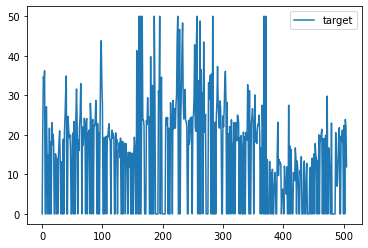

In [33]:
yb2.plot();

In [34]:
## intial estimation, HC3 error

xbs = pd.DataFrame(ss.fit_transform(Xb), columns=Xb.columns)

p0 = 1.5

twd = sma.GLM(endog=yb2, exog=sma.add_constant(xbs), family=sma.families.Tweedie(var_power=p0, eql=True))
res = twd.fit(cov_type='HC3', maxiter=1000, tol=1e-12)
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                  506
Model:                            GLM   Df Residuals:                      492
Model Family:                 Tweedie   Df Model:                           13
Link Function:                    log   Scale:                          2.3556
Method:                          IRLS   Log-Likelihood:                -2305.0
Date:                Tue, 29 Mar 2022   Deviance:                       2977.4
Time:                        09:05:04   Pearson chi2:                 1.16e+03
No. Iterations:                    25                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6121      0.035     74.398      0.0

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [35]:
print("Estimated Tweedie Power using R Method Built into TweedieElasticNet")
etp = TweedieElasticNet.r_tweedie_power_est(yb2, sma.add_constant(xbs), figsize=None)
print(etp[0])

Estimated Tweedie Power using R Method Built into TweedieElasticNet


R object inheriting from "POSIXct" but without attribute "tzone".


1.1 1.15 1.2 1.25 1.3 1.35 1.4 1.45 1.5 1.55 1.6 1.65 1.7 1.75 1.8 1.85 1.9 
.................Done.
1.1


In [36]:
twd.estimate_tweedie_power(res.mu)

1.0459740194698848

In [76]:
def loglike_p(p, res):
    return -tweedie_dist.tweedie(mu=res.mu, p=p, phi=res.scale).logpdf(res._endog).sum()

def optm(p, res):
    opt = sp.optimize.minimize_scalar(loglike_p, tol=1e-12, 
                                      bounds=(1.05, 1.1), args=(res), method='bounded')
    return opt

print(optm(1.046, res))

     fun: 349.04186423782664
 message: 'Solution found.'
    nfev: 30
  status: 0
 success: True
       x: 1.0999999731254753


<font color=red size=5>**SUCCESFUL IMPLEMENTATION!**</font>

In [77]:
# help(tweedie_dist.estimate_tweedie_loglike_series)

In [81]:
import tweedie_dist
import scipy as sp

def loglike_p(p, res):
    return -tweedie_dist.tweedie(mu=res.mu, p=p, phi=res.scale).logpdf(res._endog).sum()
#     return tweedie_dist.estimate_tweedie_loglike_series(x=res._endog, mu=res.mu, 
#                                                         p=p*np.ones_like(res.mu), 
#                                                         phi=res.scale*np.ones_like(res.mu)).sum()

def optm(p, res):
    opt = sp.optimize.minimize_scalar(loglike_p, tol=1e-20, 
                                      bounds=(1.05, 1.95), args=(res), method='bounded')
    return opt

def tweedie_profile_sm(X, y, p, tolf=1e-20):
    tol0 = 1
    pests = []
    while tol0 > tolf:
        p0 = p
        mod = sma.GLM(endog=y, exog=X, family=sma.families.Tweedie(var_power=p, eql=True), offset=None)
        res = mod.fit(maxiter=1000, tol=1e-12)
        optimal = optm(p0,res)
        p = optimal.x
        pests.append(p)
        tol0 = p0 - p
    
    return p, pests, res.llf, optimal.fun

In [82]:
tweedie_profile_sm(sma.add_constant(xbs), yb2, 1.5)

(1.5059073741495816,
 [1.5059073741495816],
 -2305.018958665033,
 1840.7649517304394)

In [86]:
ips = []
for ip in np.arange(1.05,1.95,.05):
    ip = np.round(ip,2)
    itmp = tweedie_profile_sm(sma.add_constant(xbs), yb2, ip)
    ips.append([ip, itmp[0], itmp[3]])
    print(ip, end='  ')
ip_df = pd.DataFrame(ips, columns=['pchk','pwr_est','fval']).set_index('pchk')

1.05  1.1  1.15  1.2  1.25  1.3  1.35  1.4  1.45  1.5  1.55  1.6  1.65  1.7  1.75  1.8  1.85  1.9  

pchk
1.05    1.135538
Name: pwr_est, dtype: float64


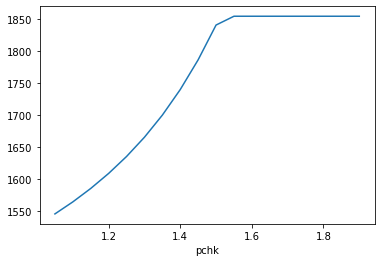

In [88]:
ip_df.fval.plot();

print(ip_df[ip_df.fval == ip_df.fval.min()]['pwr_est'])

In [90]:
ips = []
for ip in np.arange(1.05,1.95,.05):
    ip = np.round(ip,2)
    itmp = tweedie_profile_sm(sma.add_constant(xfs), y, ip)
    ips.append([ip, itmp[0], itmp[3]])
    print(ip, end='  ')
ip_df = pd.DataFrame(ips, columns=['pchk','pwr_est','fval']).set_index('pchk')

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.


1.05  1.1  1.15  1.2  1.25  1.3  1.35  1.4  1.45  1.5  1.55  1.6  1.65  1.7  1.75  1.8  1.85  1.9  

pchk
1.65    1.539217
Name: pwr_est, dtype: float64


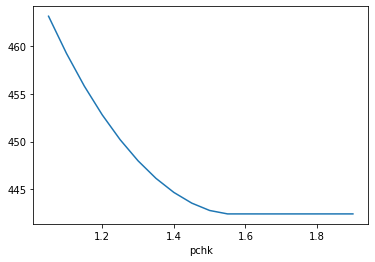

In [91]:
ip_df.fval.plot();

print(ip_df[ip_df.fval == ip_df.fval.min()]['pwr_est'])

**R had 1.41 though for the fish data.**

In [92]:
ip_df

pwr_est        fval
pchk                      
1.05  1.604108  463.112813
1.10  1.592369  459.230569
1.15  1.581798  455.796086
1.20  1.572398  452.789208
1.25  1.564164  450.190381
1.30  1.557089  447.981526
1.35  1.551165  446.146895
1.40  1.546390  444.673901
1.45  1.542768  443.553954
1.50  1.540311  442.783363
1.55  1.539220  442.425708
1.60  1.539221  442.425918
1.65  1.539217  442.424745
1.70  1.539218  442.425034
1.75  1.539219  442.425444
1.80  1.539221  442.425928
1.85  1.539222  442.426408
1.90  1.539223  442.426757

In [125]:
data = []
for pwr in np.arange(1.05,1.95,.01):
    pwr = np.round(pwr,2)
    
    mod = sma.GLM(endog=yb2, exog=sma.add_constant(xbs), family=sma.families.Tweedie(var_power=pwr, eql=True), offset=None)
    res = mod.fit(cov_type='HC3', maxiter=10000, tol=1e-20, method='irls') 
        
    phi = estimate_x2_scale(res.model.endog, res.mu, pwr, res.model.iweights)
    
    lle = tweedie_dist.estimate_tweedie_loglike_series(res.model.endog, res.mu, 
                                                         phi*np.ones(len(res.model.endog)), 
                                                         pwr*np.ones(len(res.model.endog)))
#     llem = lle.mean()
    lles = lle.sum()
    data.append([pwr, lles, res.llf])

pd.DataFrame(data, columns=['pwr','llesum','llf'])

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


pwr       llesum          llf
0   1.05 -1569.716969 -2054.386586
1   1.06 -1568.069551 -2057.148570
2   1.07 -1569.029053 -2059.980841
3   1.08 -1571.371198 -2062.885571
4   1.09 -1574.498707 -2065.865027
5   1.10 -1578.099406 -2068.921577
6   1.11 -1582.002509 -2072.057695
7   1.12 -1586.112164 -2075.275969
8   1.13 -1590.374221 -2078.579105
9   1.14 -1594.758530 -2081.969936
10  1.15 -1599.249051 -2085.451429
11  1.16 -1603.838150 -2089.026690
12  1.17 -1608.523240 -2092.698979
13  1.18 -1613.304779 -2096.471713
14  1.19 -1618.185083 -2100.348478
15  1.20 -1623.167612 -2104.333039
16  1.21 -1628.256551 -2108.429353
17  1.22 -1633.456567 -2112.641582
18  1.23 -1638.772674 -2116.974100
19  1.24 -1644.210158 -2121.431515
20  1.25 -1649.774546 -2126.018680
21  1.26 -1655.471595 -2130.740710
22  1.27 -1661.307301 -2135.603003
23  1.28 -1667.287915 -2140.611253
24  1.29 -1673.419965 -2145.771479
25  1.30 -1679.710283 -2151.090043
26  1.31 -1686.166036 -2156.573674
27  1.32 -1692.794758 -2162.229501
28  1.33 -1699.604388 -2168.065075
29  1.34 -1706.603306 -2174.088407
30  1.35 -1713.800374 -2180.308002
31  1.36 -1721.204979 -2186.732895
32  1.37 -1728.827082 -2193.372696
33  1.38 -1736.677266 -2200.237634
34  1.39 -1744.766794 -2207.338612
35  1.40 -1753.107666 -2214.687257
36  1.41 -1761.712684 -2222.295985
37  1.42 -1770.595526 -2230.178071
38  1.43 -1779.770821 -2238.347720
39  1.44 -1789.254240 -2246.820151
40  1.45 -1799.062588 -2255.611693
41  1.46 -1809.213911 -2264.739881
42  1.47 -1819.727614 -2274.223577
43  1.48 -1830.624596 -2284.083093
44  1.49 -1841.927388 -2294.340334
45  1.50 -1853.660329 -2305.018959
46  1.51 -1865.849738 -2316.144556
47  1.52 -1878.524130 -2327.744849
48  1.53 -1891.714446 -2339.849920
49  1.54 -1905.454317 -2352.492466
50  1.55 -1919.780365 -2365.708093
51  1.56 -1934.732538 -2379.535642
52  1.57 -1950.354502 -2394.017570
53  1.58 -1966.694083 -2409.200376
54  1.59 -1983.803771 -2425.135095
55  1.60 -2001.741306 -2441.877868
56  1.61 -2020.570351 -2459.490593
57  1.62 -2040.361269 -2478.041684
58  1.63 -2061.192031 -2497.606951
59  1.64 -2083.149272 -2518.270628
60  1.65 -2106.329525 -2540.126578
61  1.66 -2130.840685 -2563.279703
62  1.67 -2156.803721 -2587.847623
63  1.68 -2184.354725 -2613.962662
64  1.69 -2213.647348 -2641.774215
65  1.70 -2244.855729 -2671.451600
66  1.71 -2278.178025 -2703.187487
67  1.72 -2313.840702 -2737.202072
68  1.73 -2352.103775 -2773.748172
69  1.74 -2393.267261 -2813.117500
70  1.75 -2437.679181 -2855.648442
71  1.76 -2485.745557 -2901.735783
72  1.77 -2537.943025 -2951.842967
73  1.78 -2594.834879 -3006.517700
74  1.79 -2657.091710 -3066.412012
75  1.80 -2725.518223 -3132.308342
76  1.81 -2801.088535 -3205.153849
77  1.82 -2884.993235 -3286.106177
78  1.83 -2978.703047 -3376.595354
79  1.84 -3084.056375 -3478.408915
80  1.85 -3203.381864 -3593.811072
81  1.86 -3339.673486 -3725.712955
82  1.87 -3496.846431 -3877.921425
83  1.88 -3680.120953 -4055.512298
84  1.89 -3896.615579 -4265.407141
85  1.90 -4156.296243 -4517.296148
86  1.91 -4473.558183 -4825.176264
87  1.92 -4869.994252 -5210.042910
88  1.93 -5379.536076 -5704.888886
89  1.94 -6058.736359 -6364.702195

### Try this a couple more times with random data

- trial 1 settled on R = 1.47, Statsmodels = 2.08, other=1.59, and LLF = 1.05
- trial 1 settled on R = 1.47, Statsmodels = 2.08, other=1.59, and LLF = 1.05

In [41]:
# help(sp.random.negative_binomial)
# help(sp.random.randn)
# help(lam_alp_gam)

In [42]:
lam, alp, gam = lam_alp_gam(0.5, 1.5, 1.5)
lam, alp, gam

(0.9428090415820635, -1.0, 0.5303300858899107)

In [43]:
# help(np.random.gamma)

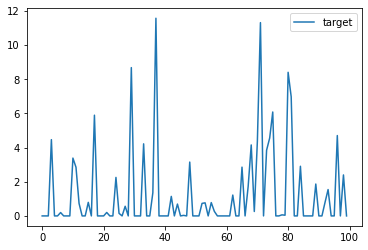

In [44]:
# Generating Poisson random sample
N = np.random.poisson(.5, 100)

rt = np.empty(100)
for i in range(100):
# Generate single data point of gamma distribution using poisson random variable
    rt[i] = np.random.gamma(N[i] * np.abs(-1.0), 2.5, 1)

yr = pd.DataFrame(rt, columns=['target'])
yr.plot();

In [45]:
def loglike_p(p, res):
    return -tweedie_dist.tweedie(mu=res.mu, p=p, phi=res.scale).logpdf(res._endog).sum()

def optm(p, res):
    opt = sp.optimize.minimize_scalar(loglike_p, tol=1e-20, 
                                      bounds=(1.05, 1.95), args=(res), method='bounded')
    return opt

In [47]:
for j in range(10):
    # Generating Poisson random sample
    pois = np.random.poisson(.5, 100)

    rt = np.empty(100)
    for i in range(100):
    # Generate single data point of gamma distribution using poisson random variable
        rt[i] = np.random.gamma(pois[i] * np.abs(-1.0), 2.5, 1)

    yr = pd.DataFrame(rt, columns=['target'])
    pct_to_zero = 0.35
    samp_idx = yr.sample(frac=pct_to_zero, random_state=123).index

    yr2 = yr.copy()
#     yr2[yr2.index.isin(samp_idx)] = 0
    print(yr2.head().T)

    Xr = pd.DataFrame(sp.random.randn(100,5), columns=[f'x{i}' for i in range(1,6)])
    Xr.shape

    xrs = pd.DataFrame(ss.fit_transform(Xr), columns=Xr.columns)
    p0 = 1.5

    twd = sma.GLM(endog=yr2, exog=sma.add_constant(xrs), family=sma.families.Tweedie(var_power=p0, eql=True))
    res = twd.fit(cov_type='HC3', maxiter=1000, tol=1e-12)
#     print(res.summary())
    print(res.params.to_frame().T)

    print("Estimated Tweedie Power using R Method Built into TweedieElasticNet")
    etp = TweedieElasticNet.r_tweedie_power_est(yr2, sma.add_constant(xrs), figsize=None)
#     print(etp[0])

    try:
        pyp = twd.estimate_tweedie_power(res.mu)
    except:
        pyp = 0.0
#     print(pyp)
#     print(optm(p0, res))

    data2 = []
    for pwr in np.arange(1.04,1.96,.02):
        pwr = np.round(pwr,2)
        mod2 = sma.GLM(endog=yr2, exog=sma.add_constant(xrs), family=sma.families.Tweedie(var_power=pwr, eql=True), offset=None)
        res2 = mod2.fit(cov_type='HC3', maxiter=10000, tol=1e-20, method='irls') 

        phi = estimate_x2_scale(res2.model.endog, res2.mu, pwr, res2.model.iweights)
    #     lle = tweedie_dist.estimate_tweedie_loglike_series(res2.model.endog, res2.mu, 
    #                                                          phi*np.ones(len(res2.model.endog)), 
    #                                                          pwr*np.ones(len(res2.model.endog)))

        data2.append([pwr, res.llf])

    out = pd.DataFrame(data2, columns=['pwr','llf']).set_index('pwr')
    outp = out[out.values == out.max().values].index
#     print(out.max(), outp)


    optm1 = optm(p0,res).x
    optm2 = tweedie_profile_sm(sma.add_constant(xrs), yr2, p0)

    print(f"iter = {j} : R = {etp[0] :.4f},   Statm = {pyp :.4f},    Optm = {optm2 :.4f},    LLF = {outp[0] : .4f}")
    print("========================================================================\n")

          0    1         2         3    4
target  0.0  0.0  4.621916  1.855473  0.0
      const        x1        x2        x3        x4        x5
0  0.150226 -0.050186 -0.051765 -0.025951 -0.117001 -0.049736
Estimated Tweedie Power using R Method Built into TweedieElasticNet


In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
R object inheriting from "POSIXct" but without attribute "tzone".


1.1 1.15 1.2 1.25 1.3 1.35 1.4 1.45 1.5 1.55 1.6 1.65 1.7 1.75 1.8 1.85 1.9 
.................Done.


Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


iter = 0 : R = 1.5408,   Statm = 2.0610,    Optm = 1.5412,    LLF =  1.0400

               0         1    2         3    4
target  0.751342  4.692034  0.0  0.999618  0.0
      const        x1        x2        x3      x4        x5
0  0.093349  0.161642  0.187969  0.222218  0.0157 -0.231825
Estimated Tweedie Power using R Method Built into TweedieElasticNet


R object inheriting from "POSIXct" but without attribute "tzone".


1.1 1.15 1.2 1.25 1.3 1.35 1.4 1.45 1.5 1.55 1.6 1.65 1.7 1.75 1.8 1.85 1.9 
.................Done.


Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


iter = 1 : R = 1.5245,   Statm = 1.8540,    Optm = 1.5004,    LLF =  1.0400

               0    1    2    3         4
target  1.467012  0.0  0.0  0.0  0.143726
      const        x1        x2        x3        x4        x5
0  0.223326  0.331471 -0.123594  0.090301 -0.462154  0.234561
Estimated Tweedie Power using R Method Built into TweedieElasticNet


R object inheriting from "POSIXct" but without attribute "tzone".


1.1 1.15 1.2 1.25 1.3 1.35 1.4 1.45 1.5 1.55 1.6 1.65 1.7 1.75 1.8 1.85 1.9 
.................Done.


Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


iter = 2 : R = 1.5327,   Statm = 2.2780,    Optm = 1.5531,    LLF =  1.0400

          0         1         2    3         4
target  0.0  2.208511  6.700329  0.0  8.966871
      const        x1       x2        x3        x4       x5
0 -0.036348 -0.003387 -0.29513 -0.143227  0.013758  0.39525
Estimated Tweedie Power using R Method Built into TweedieElasticNet


R object inheriting from "POSIXct" but without attribute "tzone".


1.1 1.15 1.2 1.25 1.3 1.35 1.4 1.45 1.5 1.55 1.6 1.65 1.7 1.75 1.8 1.85 1.9 
.................Done.


Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


iter = 3 : R = 1.5173,   Statm = 1.2711,    Optm = 1.5033,    LLF =  1.0400

               0    1    2    3    4
target  6.449498  0.0  0.0  0.0  0.0
      const        x1        x2        x3        x4        x5
0 -0.233431 -0.149835 -0.639114 -0.324257  0.309647 -0.057655
Estimated Tweedie Power using R Method Built into TweedieElasticNet


R object inheriting from "POSIXct" but without attribute "tzone".


1.1 1.15 1.2 1.25 1.3 1.35 1.4 1.45 1.5 1.55 1.6 1.65 1.7 1.75 1.8 1.85 1.9 
.................Done.


Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.


iter = 4 : R = 1.4429,   Statm = 1.5508,    Optm = 1.4176,    LLF =  1.0400

          0    1    2    3    4
target  0.0  0.0  0.0  0.0  0.0
      const        x1       x2        x3        x4        x5
0 -0.117597  0.332369 -0.02563 -0.362501 -0.529614 -0.417972
Estimated Tweedie Power using R Method Built into TweedieElasticNet


In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
R object inheriting from "POSIXct" but without attribute "tzone".


1.1 1.15 1.2 1.25 1.3 1.35 1.4 1.45 1.5 1.55 1.6 1.65 1.7 1.75 1.8 1.85 1.9 
.................Done.


Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.


iter = 5 : R = 1.3939,   Statm = 1.5769,    Optm = 1.3799,    LLF =  1.0400

          0    1    2         3    4
target  0.0  0.0  0.0  8.080121  0.0
      const        x1        x2        x3        x4        x5
0  0.238586 -0.189939 -0.011598 -0.003369  0.059441  0.033145
Estimated Tweedie Power using R Method Built into TweedieElasticNet


In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
R object inheriting from "POSIXct" but without attribute "tzone".


1.1 1.15 1.2 1.25 1.3 1.35 1.4 1.45 1.5 1.55 1.6 1.65 1.7 1.75 1.8 1.85 1.9 
.................Done.


Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


iter = 6 : R = 1.5245,   Statm = 0.0000,    Optm = 1.5232,    LLF =  1.0400

          0         1         2         3         4
target  0.0  2.454529  1.513307  0.222896  0.173303
      const        x1        x2        x3        x4        x5
0  0.171154  0.049711  0.336261 -0.033221 -0.014618 -0.012048
Estimated Tweedie Power using R Method Built into TweedieElasticNet


R object inheriting from "POSIXct" but without attribute "tzone".


1.1 1.15 1.2 1.25 1.3 1.35 1.4 1.45 1.5 1.55 1.6 1.65 1.7 1.75 1.8 1.85 1.9 
.................Done.


Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


iter = 7 : R = 1.4918,   Statm = 2.2909,    Optm = 1.4812,    LLF =  1.0400

          0    1    2    3         4
target  0.0  0.0  0.0  0.0  1.968763
      const        x1        x2        x3        x4        x5
0  0.450486  0.030289  0.059488 -0.228962 -0.058484 -0.087907
Estimated Tweedie Power using R Method Built into TweedieElasticNet


R object inheriting from "POSIXct" but without attribute "tzone".


1.1 1.15 1.2 1.25 1.3 1.35 1.4 1.45 1.5 1.55 1.6 1.65 1.7 1.75 1.8 1.85 1.9 
.................Done.


Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


iter = 8 : R = 1.4918,   Statm = 1.2522,    Optm = 1.5218,    LLF =  1.0400

          0         1    2    3    4
target  0.0  1.692591  0.0  0.0  0.0
      const        x1        x2        x3        x4       x5
0  0.244402  0.233967 -0.124936  0.098401 -0.094572 -0.21457
Estimated Tweedie Power using R Method Built into TweedieElasticNet


R object inheriting from "POSIXct" but without attribute "tzone".


1.1 1.15 1.2 1.25 1.3 1.35 1.4 1.45 1.5 1.55 1.6 1.65 1.7 1.75 1.8 1.85 1.9 
.................Done.
iter = 9 : R = 1.5571,   Statm = 1.4923,    Optm = 1.5654,    LLF =  1.0400



Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.


### all things considered, optm isnt that bad...

In [89]:
break

SyntaxError: 'break' outside loop (<ipython-input-89-6aaf1f276005>, line 4)

In [186]:
optimize_twd_pwr_qd(res.model.endog, res.mu, 1.5, res.model.iweights)

Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.


     fun: 1.73130842995306e-10
 message: 'Solution found.'
    nfev: 24
  status: 0
 success: True
       x: 1.5509765513926428

In [90]:
def loglike_p(p, res):
#     phi = -2*deviance(res.model.endog, res.mu, p).sum()/len(res.model.endog) ## this basically broke everything
#     phi = res.scale
    phi = dispersion(res.model.endog, res.mu).sum()
#     return -2*tweedie_dist.tweedie(mu=res.mu, p=p, phi=phi).logpdf(res._endog).sum()
#     return -2*np.sum(np.log(tweedie_dist.tweedie(mu=res.mu, p=p, phi=phi).pdf(res.model.endog)))

    return tweedie_dist.estimate_tweedie_loglike_series(res.model.endog, res.mu, 
                                                        res.scale*np.ones(len(res.model.endog)), 
                                                        p*np.ones(len(res.model.endog)), ).sum()

def tweedie_profile(X, y, p, tolf=1e-6):
    tol0 = 1
    iters = 0
    while (tol0 > tolf) | (iters<=100):
        p0 = p
        mod = sma.GLM(endog=y, exog=X, family=sma.families.Tweedie(var_power=p, eql=True), offset=None)
        res = mod.fit(cov_type='HC3', maxiter=1000, tol=1e-12)
    
        opt = sp.optimize.minimize_scalar(loglike_p, bounds=(1.05, 1.95), args=(res), method='bounded', tol=1e-20)
        p = opt.x
        tol0 = p0 - p
        iters+=1
    
    return p

tweedie_profile(sma.add_constant(xbs), yb2, p0)

1.9499999583462466

### Dunn and Smyth 2005 Series Expansion

In [239]:
## I see where I am at now relative to R
## jmax estimate - @ dtweedie.jw.smallp <- function(y, phi, power )
def jw_smallp(power, y, phi):
    '''p is power, a is alp'''
    from scipy.special import gammaln, gamma
    
    p = power
    a = (2-p)/(1-p)
    a1 = 1 - a
    r = -a*np.log(y) + a*np.log(p-1) - a1*np.log(phi) - np.log(2-p) # All terms to power j

    drop = 37             # Accuracy of terms: exp(-37)
    # Find limits of summation using Stirling's approximation
    # to approximate gamma terms, and find max as j.max
    logz = max(r)   # To find largest  j  needed
    j_max = max( y**( 2-p ) / ( phi * (2-p) ) )
    j = max( 1, j_max )
    
    c = logz + a1 + a*np.log(-a)
    wmax = a1*j_max
    estlogw = wmax
  
    # First, the upper limit of j
    while estlogw > (wmax-drop):
        j = j + 2
        estlogw = j*(c - a1*np.log(j))
         
    hi_j = np.ceil(j)
    
    # Now the lower limit of j
    logz = min(r) 
    j_max = min( y**( 2-power ) / ( phi * (2-power) ) )
    
    j = max(1, j_max)
    wmax = a1*j_max 
    estlogw = wmax 
    while (estlogw > (wmax-drop)) & (j>=2):
        j = max(1, j-2)
        oldestlogw = estlogw
        estlogw = j*(c-a1*np.log(j))
    
    lo_j = max(1, np.floor(j))            
    # Now sum the series between established limits.
    # We ensure it works for vector y.
    j = np.arange(lo_j, hi_j + 1) ## j <- seq( lo.j, hi.j)  # sequence of j terms needed
    o = np.ones((len(y),1)) ## o <- matrix( 1, nrow=length(y))     # matrix of ones
    
    g = (gammaln(j+1) + gammaln(-a*j)).reshape(-1,1)  ## g <- matrix(lgamma( j+1 ) + lgamma( -a*j ), nrow=1, ncol=hi.j - lo.j + 1) 
    og = o.dot(g.T) ## logj <- matrix(log(j), nrow=1, ncol=hi.j - lo.j + 1) 
    logj = np.log(j).reshape(-1,1) ## og <- o %*% g  # matrix of gamma terms
    ologj = o.dot(logj.T) ## ologj <- o %*% logj

    A = np.outer(r,j) - og + ologj # the series almost ready to sum   A <- outer(r,j) - og + ologj
    m = np.max(A, axis=1).reshape(-1,1) # avoid overflow, find max values  m <- apply(A,1,max)
    we = np.exp(A - m) ## we <- exp( A - m )  # evaluate terms, less max.
    we_sum = np.sum(we, axis=1) ## sum.we <- apply( we,1,sum)  # sum terms
    
    #     jw <- sum.we * exp( m )                # now restore max.
    #     # Since derivs may be negative, can't use log-scale
    jw = we_sum * np.exp(m) 
    
    return hi_j, lo_j, j, jw, m

In [141]:
## I see where I am at now relative to R
## jmax estimate - @ dtweedie.jw.smallp <- function(y, phi, power )

# def logl(phi, y, mu, power):
#     return np.sum(np.log())

def logw_smallp(power, y, phi):
    '''p is power, a is alp'''
    from scipy.special import gammaln, gamma
    
    p = power
    a = (2-p)/(1-p)
    a1 = 1 - a
    r = -a*np.log(y) + a*np.log(p-1) - a1*np.log(phi) - np.log(2-p) # All terms to power j

    drop = 37             # Accuracy of terms: exp(-37)
    # Find limits of summation using Stirling's approximation
    # to approximate gamma terms, and find max as j.max
    logz = max(r)   # To find largest  j  needed
    j_max = max( y**( 2-p ) / ( phi * (2-p) ) )
    j = max( 1, j_max )
    
    c = logz + a1 + a*np.log(-a)
    wmax = a1*j_max
    estlogw = wmax
  
    # First, the upper limit of j
    while estlogw > (wmax-drop):
        j = j + 2
        estlogw = j*(c - a1*np.log(j))
         
    hi_j = np.ceil(j)
    
    # Now the lower limit of j
    logz = min(r) 
    j_max = min( y**( 2-power ) / ( phi * (2-power) ) )
    
    j = max(1, j_max)
    wmax = a1*j_max 
    estlogw = wmax 
    while (estlogw > (wmax-drop)) & (j>=2):
        j = max(1, j-2)
        oldestlogw = estlogw
        estlogw = j*(c-a1*np.log(j))
    
    lo_j = max(1, np.floor(j))            
    # Now sum the series between established limits.
    # We ensure it works for vector y.
    j = np.arange(lo_j, hi_j + 1) ## j <- seq( lo.j, hi.j)  # sequence of j terms needed
    o = np.ones((len(y),1)) ## o <- matrix( 1, nrow=length(y))     # matrix of ones
    
    g = (gammaln(j+1) + gammaln(-a*j)).reshape(-1,1)  ## g <- matrix(lgamma( j+1 ) + lgamma( -a*j ), nrow=1, ncol=hi.j - lo.j + 1) 
    og = o.dot(g.T) ## logj <- matrix(log(j), nrow=1, ncol=hi.j - lo.j + 1) 
    #logj = np.log(j).reshape(-1,1) ## og <- o %*% g  # matrix of gamma terms
    #ologj = o.dot(logj.T) ## ologj <- o %*% logj

    A = np.outer(r,j) - og # + ologj # the series almost ready to sum   A <- outer(r,j) - og + ologj
    m = np.max(A, axis=1).reshape(-1,1) # avoid overflow, find max values  m <- apply(A,1,max)
    we = np.exp(A - m) ## we <- exp( A - m )  # evaluate terms, less max.
    we_sum = np.sum(we, axis=1) ## sum.we <- apply( we,1,sum)  # sum terms
    
    logw = np.log(we_sum) + m
    
    return hi_j, lo_j, j_max, logw

In [160]:
def tseries(power, y, mu, phi):
    
    res = logw_smallp(power, y, phi)
    logw = res[-1]
    logw = np.where(~(np.isfinite(logw)), 0, logw)
    
    tau = phi*(power-1)*mu**(power-1)
    lam = mu**(2-power) / (phi*(2-power))
#     print(y.shape, tau.shape, lam.shape, logw.shape)
#     print(logw.sum()) ## not nan
    logf = -y/tau - lam + np.log(y) + logw.sum()
    f = np.exp(logf)
    density = f
    
    return density, logw

In [161]:
# for p in np.arange(1.05,1.95,.05):
#     dens, logw = tseries(p, twd.endog, res.mu, res.scale)
#     print(dens.sum())

In [164]:
mu = res.mu
phi = res.scale
p = 1.5

lam = mu**(2-p) / (phi*(2-p))
alp = (2-p)/(1-p)
gam = phi*(p-1) * mu**(p-1)

jms = []
for p in np.arange(1.05, 1.95, .01):
    
    mod1 = sma.GLM(endog=yf, exog=sma.add_constant(xfs),  
                   family=sma.families.Tweedie(var_power=p, eql=True), offset=None)
    res1 = mod1.fit(cov_type='HC3', maxiter=1000, tol=1e-12)
    phi = res1.scale
#     phi = dispersion(yf, res1.mu)
    mu = res1.mu
    
    alp = (2-p)/(1-p)
#     jw = jw_smallp(p, yf, alp, phi)

#     jw = logw_smallp(p, yf, phi)
    
    jw = tseries(p, yf, mu, phi)
    
    jms.append((p,np.ma.masked_invalid(jw[-1]).sum()))
    
    q = sma.add_constant(xfs).shape[1]
    n = len(yf)
    dev = res1.deviance
    new_scale = 1/(n-q) * np.ma.masked_invalid(jw[-1]*dev).sum() 
#     print(new_scale, p)
    
#     print(p, np.ma.masked_invalid(jmax[-1]).sum())


In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
divide by zero encountered in log
invalid value encountered in subtract
overflow encountered in exp


<AxesSubplot:xlabel='pwr'>

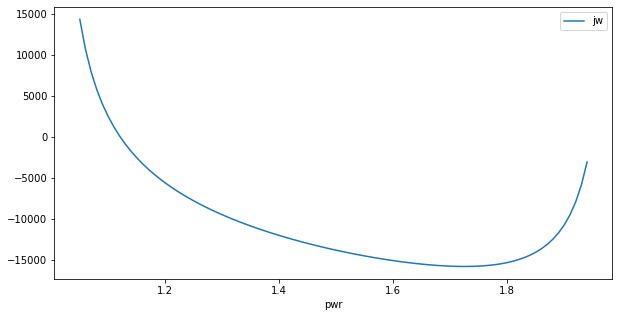

In [165]:
fig, ax=plt.subplots(1,1,figsize=(10,5))
pd.DataFrame(jms, columns=['pwr','jw']).set_index('pwr').plot(ax=ax)
# ax.axvline(np.argmin(jms[0,:]), color='r', alpha=0.5);

In [37]:
from scipy.special import factorial, gammaln, gamma

mu = res.mu
phi = res.scale
# p = 1.5

chk = []
powers = np.arange(1.05,2.0,0.05)
for p in powers:
    
    lam = mu**(2-p) / (phi*(2-p))
    alp = (2-p)/(1-p)
    gam = phi*(p-1) * mu**(p-1)

    p_yat0 = np.exp(-lam)
    # print(p_yat0)

    ## for y>0

    Wj = 0
    for j in range(10):
        ja = j*alp
        num = y**(-ja) * (p-1)**(ja)
        den = phi**(j-ja) * (2-p)**j * factorial(j) * gamma(-ja)
        Wj += num/den

    W_yp = Wj

    a_yphi = 1/y * W_yp

#     print(f"mu = {mu[:5]},\n phi = {phi},\n p={p}, \n P(y==0) = {p_yat0[:5]}")
#     print(f"a(y,phi) = {a_yphi[:10].flatten()}")

    ## page 7 appropriate j value

    z_num = y**(-alp) * (p-1)**(alp)
    z_den = phi**(1-alp) * (2-p)
    z = z_num/z_den

#     print(j)
    log_Wj = -np.log(2*np.pi) - 1/2 * np.log(-alp) - np.log(j)
    dlogW_dj = np.log(z) - np.log(j) + alp*(np.log(-alp*j))

    j_max = y**(2-p)/(phi*(2-p))
#     print(j_max[:5].flatten())

    log_Wmax = j_max*(alp-1) - np.log(2*np.pi) - np.log(j_max) - 1/2 * np.log(-alp)
#     print(log_Wmax[:5].flatten())

    ## need to bound from page 9?

    wj = np.exp(np.log(Wj) - log_Wmax)

    ## wj is a sum from lower bound to upperbound
    logW_hat = log_Wmax + np.log(wj)

    print(p, np.nansum(logW_hat), np.nansum(j_max))
    chk.append(np.nansum(logW_hat))

1.05 -718.7762212459988 100.63454765629359
1.1 331.7308088689721 92.16624100051672
1.1500000000000001 138.53520734819384 85.09742130186255
1.2000000000000002 40.98052186430239 79.24219475848511
1.2500000000000002 -17.480176511117858 74.45440291613642
1.3000000000000003 -55.98747843646685 70.62319023358512
1.3500000000000003 -82.91702534930923 67.67054976007515
1.4000000000000004 -102.50711265153171 65.55110608623963
1.4500000000000004 -117.08068083514351 64.25478704603412
1.5000000000000004 -127.96574025367843 63.81373360469741
1.5500000000000005 -135.91736723094354 64.31615183429254
1.6000000000000005 -141.3112614122152 65.9326524354074
1.6500000000000006 -144.21038947360836 68.96708524796185
1.7000000000000006 -144.3278211825073 73.96000082596916
1.7500000000000007 -140.8368220945306 81.91799143333931
1.8000000000000007 -131.82022494783877 94.88877645054589
1.8500000000000008 -112.55894680953776 117.68831794398466
1.9000000000000008 -68.63230555614659 164.81153106568033
1.95000000000

overflow encountered in multiply
overflow encountered in double_scalars
invalid value encountered in true_divide
overflow encountered in power
divide by zero encountered in true_divide
invalid value encountered in multiply
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in add


In [68]:
saddle = np.sum(res.deviance)/len(y)
saddle

3.4362219562028185

In [69]:
# lower_lim = min([0.001, saddle/2])
# upper_lim = 10*phi
# print(lower_lim, upper_lim)

**The paper says they use BFGS solver with first derivative - dlogfdphi**

In [70]:
# ## adjust profile likihood (page 14) Cox and Reid 87
# q = X.shape[1]
# D = np.eye(len(X))*weights

# apl = llf + q/2*np.log(phi) - 1/2*np.abs(np.log(X).T.D.X)

In [71]:
sig = dispersion(yf, res.mu)
sig.shape

(250,)

In [72]:
# np.log(yf)

In [73]:
poy = np.linspace(1.05, 1.95, len(yf)) #$np.arange(1.05, 2.0, 1/len(yf))
len(yf), len(poy)

(250, 250)

- https://github.com/statsmodels/statsmodels/issues/2915
- https://github.com/statsmodels/statsmodels/pull/3079
- https://github.com/statsmodels/statsmodels/issues/2858

In [80]:
# #  box cos log likelihood

# powers = np.arange(1.05,1.95,0.01)
# for p in powers:
#     p = p.round(2)
#     mod2 = sma.GLM(endog=yf, exog=sma.add_constant(xfs),  
#                    family=sma.families.Tweedie(var_power=p, eql=True), offset=None)
#     res2 = mod2.fit(cov_type='HC3', maxiter=1000, tol=1e-12)
#     sig = dispersion(yf, res2.mu)
    
# #     phin = res2.scale*np.ones(len(yf))
#     phin = dispersion(yf, res2.mu)
    
#     pn = p*np.ones(len(yf))
#     tmp = tweedie_dist.estimate_tweedie_loglike_series(yf, res2.mu, phin, pn)
    
#     chk = -1/2 *np.sum( np.log(2*np.pi*sig**2) + ((yf - res2.mu)/sig)**2 + p*np.log(yf).replace(-np.inf,0) )
#     print(p, chk, np.nansum(tmp))

Nope

In [78]:
# (1.5+1.25)/2

1.375

In [54]:
phin = dispersion(yf, res2.mu)
phin

0     -92.592289
1     -92.161732
2     -92.353539
3     -92.476091
4     -92.721800
         ...    
245   -91.211999
246   -92.621994
247   -92.476091
248   -92.584630
249   -92.476091
Name: FISH_COUNT, Length: 250, dtype: float64

In [55]:
# tmp = tweedie_dist.estimate_tweedie_loglike_series(yf, res2.mu, phin, poy)
## too long

pn = 1.5*np.ones(len(yf))

tmp = tweedie_dist.estimate_tweedie_loglike_series(yf, res2.mu, phin, pn)

In [56]:
tmp.sum()

-814.0612978964955

In [9]:
sas_power = 1.4023

twd = sma.GLM(endog=y, exog=sma.add_constant(xfs), 
              family=sma.families.Tweedie(var_power=sas_power, eql=True))

print("="*20," Normal Fit ","="*20)
tfit = twd.fit(maxiter=1000, tol=1e-12)
print(tfit.cov_type)
print(tfit.summary())

print("="*20," HC3 Fit ","="*20)
tfit_hc3 = twd.fit(cov_type='HC3', maxiter=1000, tol=1e-12)
print(tfit_hc3.cov_type)
print(tfit_hc3.summary().tables[1])

print("="*20," HAC (NeweyWest) Fit ","="*20)
tfit_nw = twd.fit(cov_type='HAC', cov_kwds={'maxlags':12}, maxiter=1000, tol=1e-12)
print(tfit_nw.cov_type)
print(tfit_nw.summary().tables[1])

====================  Normal Fit  ====================
nonrobust
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  250
Model:                            GLM   Df Residuals:                      245
Model Family:                 Tweedie   Df Model:                            4
Link Function:                    log   Scale:                          7.6404
Method:                          IRLS   Log-Likelihood:                -554.54
Date:                Thu, 03 Mar 2022   Deviance:                       841.62
Time:                        17:28:57   Pearson chi2:                 1.87e+03
No. Iterations:                    18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [10]:
# tfit.wald_test(tfit.resid_working)

### Comparison with R

link.power = 0 is the log link

**R Code:**

library(tweedie)
library(statmod)
library(lmtest)
library(sandwich)

df <- read.csv(data='data/fish.csv')

m1 <- glm(FISH_COUNT~., data=df, family=tweedie(var.power=1.4, link.power=0))

summary(m1)

coeftest(m1, vcov=vcovHC(m1, type='HC3'))

coeftest(m1, vcov=NeweyWest(m1, lag=12, prewhite=F))

In [11]:
from statsmodels.iolib import SimpleTable
from statsmodels.iolib.tableformatting import (gen_fmt, fmt_2, fmt_params)

In [12]:
def r_summary_model(model, X):
    """ Create a dict with information about the model """
    import datetime as dt
    from statsmodels.iolib import SimpleTable
    from statsmodels.iolib.tableformatting import (gen_fmt, fmt_2, fmt_params)
    from statsmodels.iolib.summary import forg
#         model = self.model

    info = {}
    info['Model:'] = 'Tweedie with Varying Error Types'
    info['Date:'] = dt.datetime.now().strftime('%Y-%m-%d %H:%M')
    info['Df Model:'] = rbase.summary(model).rx2('df')[0]
    info['Df Residuals:'] = model.rx2('df.residual')[0]
#     info['Converged:'] = rbase.summary(model).rx2('converged')[0]
    info['Deviance:'] = rbase.summary(model).rx2('deviance')[0]
    info['Dispersion:'] = rbase.summary(model).rx2('dispersion')[0]
    info['Iters:'] = rbase.summary(model).rx2('iter')[0]

    out = pd.DataFrame(info, index=range(len(info))).T.iloc[:,0]
    model_coefs = rbase.summary(model).rx2('coefficients')
    orig_data = model.rx2('model')
    var_names = ['Intercept'] + list(X.columns) #self.X.columns)
    
    cov = rbase.summary(model).rx2('cov.scaled')

    model_data = list(info.items())
    mt = SimpleTable(model_data, txt_fmt=fmt_params)

    params_data = []
    for i in range(model_coefs.shape[0]):
        curr_row = model_coefs[i,:]
#         params_data.append([forg(j, prec=4) for j in curr_row])
        params_data.append([np.round(j,5) for j in curr_row])
    pt = SimpleTable(params_data, ['Estimate', 'Std. Error', 't value', 'Pr(>|t|)'],
                     var_names, txt_fmt=fmt_params)
    return mt, pt

In [13]:
mass = importr('MASS')
rstats = importr('stats')
robustbase = importr('robustbase')
rbase = importr('base')
rsm = importr('statmod')
rsw = importr('sandwich')
r_lmt = importr('lmtest')

R object inheriting from "POSIXct" but without attribute "tzone".


In [14]:
yR = pd.Series(y.flatten())
yR.name = 'y'

rdf = pd.concat([yR,xfs], axis=1)
rdf.head()

y  LIVE_BAIT  CAMPER  PERSONS  CHILDREN
0  0          0       0        1         0
1  0          1       1        1         0
2  0          1       0        1         0
3  0          1       1        2         1
4  1          1       0        1         0

In [15]:
## tukey defaults are S=1.55, M=4.69
cntrl_str = '''maxit=1000'''
cntrl = robjects.r('a1 <- glm.control({})'.format(cntrl_str)) 

model = rstats.glm('{} ~ .'.format(yR.name), 
                  data=rdf, family=robjects.r('tweedie(var.power={}, link.power=0)'.format(sas_power)),
                  control=cntrl)
model_coefs = rbase.summary(model).rx2('coefficients')

In [16]:
print("R Model","="*30)
for item in r_summary_model(model, X):
    print(item)

print("Statsmodels","="*30)
print(tfit.summary().tables[1])

R Model ==============================
       Model: Tweedie with Varying Error Types
        Date:                 2022-03-03 17:29
    Df Model:                                5
Df Residuals:                              245
    Deviance:                841.6208938250044
  Dispersion:                7.640315118546264
       Iters:                                5
             Estimate Std. Error    t value   Pr(>|t|)
------------------------------------------------------
Intercept    -3.11477    0.72067   -4.32203      2e-05
LIVE_BAIT     1.58167    0.62332     2.5375    0.01179
CAMPER        0.64541    0.31049    2.07866    0.03869
PERSONS       1.05683    0.13264    7.96788        0.0
CHILDREN     -1.77527    0.24616   -7.21193        0.0
Statsmodels ==============================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1148      0.721     -4.322   

In [17]:
var_names = ['Intercept'] + list(xfs.columns)

hc3_params = r_lmt.coeftest(model, vcov=rsw.vcovHC(model, type="HC3"))

st = SimpleTable(hc3_params.round(4), ['Estimate', 'Std. Error', 't value', 'Pr(>|t|)'],
                 var_names, txt_fmt=fmt_params)

print("R Model","="*30)
print(st)
print("Statsmodels","="*30)
print(tfit_hc3.summary().tables[1])

R Model ==============================
             Estimate Std. Error    t value   Pr(>|t|)
------------------------------------------------------
Intercept     -3.1148     0.5111    -6.0943        0.0
LIVE_BAIT      1.5817     0.3869     4.0885        0.0
CAMPER         0.6454     0.3458     1.8662      0.062
PERSONS        1.0568     0.1196     8.8386        0.0
CHILDREN      -1.7753     0.2308    -7.6913        0.0
Statsmodels ==============================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1148      0.471     -6.614      0.000      -4.038      -2.192
LIVE_BAIT      1.5817      0.372      4.249      0.000       0.852       2.311
CAMPER         0.6454      0.337      1.913      0.056      -0.016       1.307
PERSONS        1.0568      0.116      9.145      0.000       0.830       1.283
CHILDREN      -1.7753      0.241     -7.362      0.000     

In [18]:
nw_params = r_lmt.coeftest(model, vcov=rsw.NeweyWest(model, lag=12))

st = SimpleTable(nw_params.round(4), ['Estimate', 'Std. Error', 't value', 'Pr(>|t|)'],
                 var_names, txt_fmt=fmt_params)

print("R Model","="*30)
print(st)
print("Statsmodels","="*30)
print(tfit_nw.summary().tables[1])

R Model ==============================
             Estimate Std. Error    t value   Pr(>|t|)
------------------------------------------------------
Intercept     -3.1148     0.4899    -6.3585        0.0
LIVE_BAIT      1.5817     0.3295     4.7998        0.0
CAMPER         0.6454     0.3071     2.1016     0.0356
PERSONS        1.0568     0.1131      9.342        0.0
CHILDREN      -1.7753     0.2196    -8.0835        0.0
Statsmodels ==============================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1148      0.478     -6.519      0.000      -4.051      -2.178
LIVE_BAIT      1.5817      0.331      4.773      0.000       0.932       2.231
CAMPER         0.6454      0.305      2.116      0.034       0.048       1.243
PERSONS        1.0568      0.113      9.316      0.000       0.834       1.279
CHILDREN      -1.7753      0.235     -7.547      0.000     

In [19]:
tfit_nw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:                            GLM   Df Residuals:                      245
Model Family:                 Tweedie   Df Model:                            4
Link Function:                    log   Scale:                          7.6404
Method:                          IRLS   Log-Likelihood:                -554.54
Date:                Thu, 03 Mar 2022   Deviance:                       841.62
Time:                        17:29:21   Pearson chi2:                 1.87e+03
No. Iterations:                    18                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1148      0.478     -6.519      0.000      -4.051      -2.178
LIVE_BAIT      1.5817      0.331      4.773      0.000       0.932       2.231
CAMPER         0.6454      0.305      2.116      0.034       0.048       1.243
PERSONS        1.0568      0.113      9.316      0.000       0.834       1.279
CHILDREN      -1.7753      0.235     -7.547      0.000      -2.236      -1.314
==============================================================================
"""

In [28]:
os.getcwd()

'C:\\Users\\schillw\\OneDrive - FNBCorp\\CECL 2020-2021\\tweedie_huber_info_v2'

In [51]:
def tweedie_rout(y, X, power, path, segment):
    '''Writes an R script for ease of checking to the specified path portion.
       The path already pulls in the current working directory of the notebook.
       Returns the r_data and the script.
    '''
    import os

    cwd = os.getcwd()
    data = pd.concat([y,X],axis=1).dropna()
    data.to_csv(cwd+path+'/r_data.csv', index=False)

    y_name = data.columns[0]

    script = '''
        Packages <- c("tweedie", "statmod", "lmtest", "sandwich")
        lapply(Packages, library, character.only = TRUE)

        print("Read in the data ===================")
        df <- read.csv(file='r_data.csv')
        print("Run the Model ======================")
        m <- glm('{}~.', data=df, family=tweedie(var.power={}, link.power=0))
        print("Summary ============================")
        summary(m)
        print("Newey-West Robust Errors ===========")
        coeftest(m, vcov=NeweyWest(m, lag=12, prewhite=F))
        '''.format(y_name, power)

    with open(cwd+path+'/r_code_{}.r'.format(segment), 'w') as f:
        f.write(script)

    return data, script

In [52]:
tweedie_rout(yR, xfs, 1.4, path='/r_out_test', segment='test')

(     y  LIVE_BAIT  CAMPER  PERSONS  CHILDREN
 0    0          0       0        1         0
 1    0          1       1        1         0
 2    0          1       0        1         0
 3    0          1       1        2         1
 4    1          1       0        1         0
 ..  ..        ...     ...      ...       ...
 245  0          1       1        2         0
 246  0          1       1        4         3
 247  0          1       1        2         1
 248  0          1       1        3         2
 249  0          1       1        2         1
 
 [250 rows x 5 columns],
 '\n        Packages <- c("tweedie", "statmod", "lmtest", "sandwich")\n        lapply(Packages, library, character.only = TRUE)\n\n        print("Read in the data ===================")\n        df <- read.csv(file=\'r_data.csv\')\n        print("Run the Model ======================")\n        m <- glm(\'y~.\', data=df, family=tweedie(var.power=1.4, link.power=0))\n        print("Summary ============================")\

In [ ]:
break